# 모델링

### 1. 필요한 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 맷플롯립 한글 사용 가능
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import random

### 2. 데이터 준비

In [3]:
df = pd.read_csv('Data_Preprocessing/apt_all_numeric_information.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251096 entries, 0 to 251095
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   NO                        251096 non-null  object 
 1   latitude                  251096 non-null  float64
 2   longitude                 251096 non-null  float64
 3   brand_label_encoded       251096 non-null  float64
 4   exclusive_area_m2         251096 non-null  float64
 5   apt_age                   251096 non-null  float64
 6   floor                     251096 non-null  float64
 7   closest_station_dist_km   251096 non-null  float64
 8   station_score             251096 non-null  float64
 9   closest_bus_stop_dist_km  251096 non-null  float64
 10  bus_stop_score            251096 non-null  float64
 11  closest_school_dist_km    251096 non-null  float64
 12  school_score              251096 non-null  float64
 13  closest_hospital_dist_km  251096 non-null  f

### 3. 모델링

##### 3.1. 모델링 - 현재 화폐가치 반영한 소득 제외

In [4]:
# 현재화폐가치 반영한 소득 제외한 모델
# 샘플링
sampled_df = df.sample(n=15000, random_state=42)

# 특성과 타겟 분리
X = sampled_df.drop(columns=['NO', 'adjusted_price', 'adjusted_income'])
y = sampled_df['adjusted_price']

# 데이터 분할: 80% 학습, 20% 테스트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 기본 XGBoost 모델 초기화
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train,y_train)

print('score:', xgb_model.score(X_train,y_train), xgb_model.score(X_test,y_test))

# 교차검증 (R² 기준)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print(f"교차검증 평균 R² 점수:", cv_scores)

# 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# GridSearch 실행
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적 파라미터와 점수
print(f"최적 하이퍼파라미터: {grid_search.best_params_}")
print(f"최적 R² 점수: {grid_search.best_score_:.4f}")

# 최적 모델
best_model = grid_search.best_estimator_

# 훈련 세트 예측
y_train_pred = best_model.predict(X_train)

# 훈련 세트 평가 지표 계산
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f"훈련 세트 R²: {r2_train}")
print(f"훈련 세트 MSE: {mse_train}")
print(f"훈련 세트 RMSE: {rmse_train}")
print(f"훈련 세트 MAE: {mae_train}")

# 테스트 세트 예측
y_pred = best_model.predict(X_test)

# 평가 지표 계산
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"테스트 세트 R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

np.round( mae / y_test.mean(), 3 )
# 0.105 > 집값의 약 10% 오차

best_model.feature_importances_

score: 0.9900629800632631 0.9280239894379552
교차검증 평균 R² 점수: [0.9217793  0.91776806 0.89423281 0.91156124 0.92195416]
Fitting 3 folds for each of 54 candidates, totalling 162 fits
최적 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
최적 R² 점수: 0.9280
훈련 세트 R²: 0.9839519804986878
훈련 세트 MSE: 81707352.91827294
훈련 세트 RMSE: 9039.211963344644
훈련 세트 MAE: 6498.1962038313795
테스트 세트 R²: 0.9393203971805676
MSE: 341175036.6454888
RMSE: 18470.924087481082
MAE: 10259.610042654296


array([2.00800411e-02, 2.15544514e-02, 5.00616096e-02, 1.08739026e-01,
       3.76416929e-02, 5.95033262e-03, 8.91111791e-03, 1.90027952e-02,
       3.53401690e-03, 2.00709868e-02, 5.25005488e-03, 4.15562140e-03,
       5.85435750e-03, 1.81366522e-02, 9.86720994e-03, 1.91709958e-03,
       4.83186590e-03, 9.63187218e-03, 4.71966760e-03, 3.33906297e-04,
       9.38704908e-02, 0.00000000e+00, 3.57661978e-03, 6.11746777e-03,
       1.38021233e-02, 5.62902587e-03, 9.57582705e-03, 3.22988890e-02,
       1.05759129e-03, 0.00000000e+00, 0.00000000e+00, 1.85866107e-03,
       0.00000000e+00, 9.55706183e-03, 1.77658012e-03, 3.48092705e-01,
       3.80184967e-03, 2.02171989e-02, 1.03988750e-02, 4.09799069e-03,
       4.78617242e-03, 9.53420065e-03, 1.08571975e-02, 4.84422082e-03,
       5.33442339e-03, 4.78431070e-03, 2.64269416e-03, 3.17841722e-03,
       2.50531267e-03, 4.39903885e-03, 1.17271096e-02, 1.69361511e-03,
       6.30519120e-03, 1.43477507e-03], dtype=float32)

In [ ]:
# GridSearchCV 결과를 DataFrame으로 변환
results = pd.DataFrame(grid_search.cv_results_)

# 하이퍼파라미터와 관련된 성능 비교
# (예: n_estimators에 따른 mean_test_score 시각화)
plt.figure(figsize=(12, 6))
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', marker='o')
plt.title('Number of Estimators vs. Mean Test Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score (R²)')
plt.grid(True)
plt.show()

# 추가 시각화: max_depth, learning_rate 등 다른 하이퍼파라미터
# max_depth에 따른 성능
plt.figure(figsize=(12, 6))
sns.boxplot(data=results, x='param_max_depth', y='mean_test_score')
plt.title('Max Depth vs. Mean Test Score')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score (R²)')
plt.grid(True)
plt.show()

# learning_rate에 따른 성능
plt.figure(figsize=(12, 6))
sns.lineplot(data=results, x='param_learning_rate', y='mean_test_score', marker='o')
plt.title('Learning Rate vs. Mean Test Score')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Score (R²)')
plt.grid(True)
plt.show()

In [4]:
best_model.feature_importances_.argmax()
X_train.columns[35]
# X_train.columns[27]

'월_평균_소득_금액'

In [5]:
X_train.columns

Index(['latitude', 'longitude', 'brand_label_encoded', 'exclusive_area_m2',
       'apt_age', 'floor', 'closest_station_dist_km', 'station_score',
       'closest_bus_stop_dist_km', 'bus_stop_score', 'closest_school_dist_km',
       'school_score', 'closest_hospital_dist_km', 'hospital_score',
       'closest_park_dist_km', 'park_score', 'ldong_prev_1_month',
       'ldong_prev_3_months', 'ldong_prev_6_months', 'K_progressive_president',
       'A_progressive_president', 'A_progressive_senate',
       'A_progressive_house', 'USD_exchange_rate', 'CNY_exchange_rate',
       'JPY_exchange_rate', '한국은행_기준금리', '정부대출금금리', '무역금융지원_프로그램대출금리',
       '영세자영업자지원_프로그램대출금리', '신성장·일자리지원_프로그램대출금리', '설비투자지원_프로그램대출금리',
       '지방중소기업지원_프로그램대출금리', '자금조정_대출금리', '자금조정_예금금리', '월_평균_소득_금액',
       '식료품_지출_총금액_퍼센트', '의류_신발_지출_총금액_퍼센트', '생활용품_지출_총금액_퍼센트',
       '의료비_지출_총금액_퍼센트', '교통_지출_총금액_퍼센트', '교육_지출_총금액_퍼센트', '유흥_지출_총금액_퍼센트',
       '여가_문화_지출_총금액_퍼센트', '기타_지출_총금액_퍼센트', '음식_지출_총금액_퍼센트'],
      dtype='objec

특성 중요도 시각화

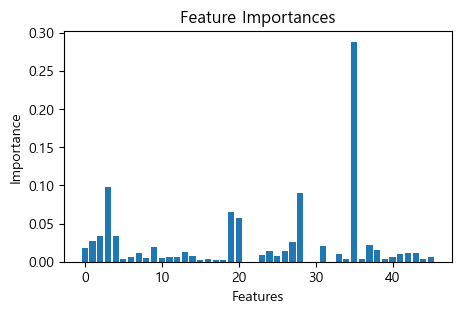

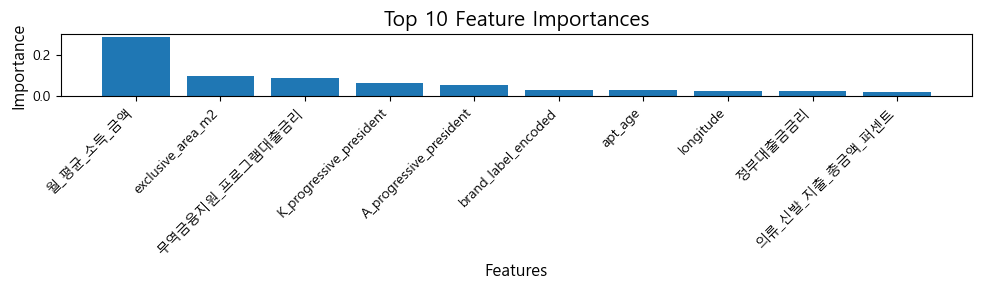

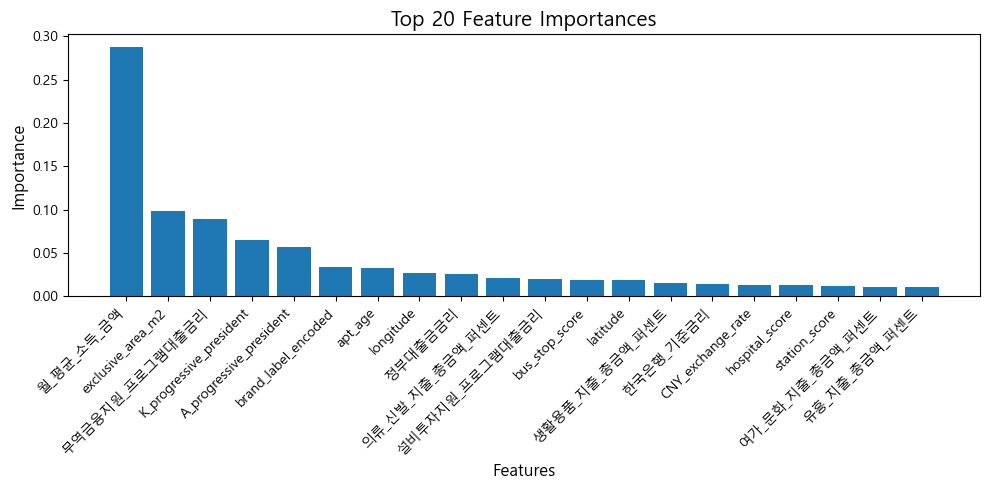

In [6]:
# 전체 Feature Importance 시각화
def plot_full_importances(model):
    plt.figure(figsize=(5, 3))
    plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
    plt.title('Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

# 상위 N개 Feature Importance 시각화
def plot_top_n_importances(model, feature_names, n=10):
    # 상위 N개 피처 추출
    top_n_indices = np.argsort(model.feature_importances_)[-n:][::-1]
    top_n_importances = model.feature_importances_[top_n_indices]
    top_n_names = [feature_names[i] for i in top_n_indices]
    
    # 시각화
    plt.figure(figsize=(10, 3 if n <= 10 else 5))  # 개수에 따라 크기 조정
    plt.bar(top_n_names, top_n_importances)
    plt.title(f'Top {n} Feature Importances', fontsize=15)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Feature 이름 리스트
feature_names = X_train.columns.tolist()

# 전체 Feature Importance 시각화
plot_full_importances(best_model)

# 상위 10개 Feature Importance 시각화
plot_top_n_importances(best_model, feature_names, n=10)

# 상위 20개 Feature Importance 시각화
plot_top_n_importances(best_model, feature_names, n=20)


##### 3.2. 원래 소득 제외한 모델

In [5]:
# 원래 소득 제외한 모델
# 샘플링
sampled_df = df.sample(n=15000, random_state=42)

# 특성과 타겟 분리
X = sampled_df.drop(columns=['NO', 'adjusted_price', '월_평균_소득_금액'])
y = sampled_df['adjusted_price']

# 데이터 분할: 80% 학습, 20% 테스트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 기본 XGBoost 모델 초기화
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train,y_train)

print('score:', xgb_model.score(X_train,y_train), xgb_model.score(X_test,y_test))

# 교차검증 (R² 기준)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print(f"교차검증 평균 R² 점수:", cv_scores)

# 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# GridSearch 실행
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적 파라미터와 점수
print(f"최적 하이퍼파라미터: {grid_search.best_params_}")
print(f"최적 R² 점수: {grid_search.best_score_:.4f}")

# 최적 모델
best_model = grid_search.best_estimator_

# 훈련 세트 예측
y_train_pred = best_model.predict(X_train)

# 훈련 세트 평가 지표 계산
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f"훈련 세트 R²: {r2_train}")
print(f"훈련 세트 MSE: {mse_train}")
print(f"훈련 세트 RMSE: {rmse_train}")
print(f"훈련 세트 MAE: {mae_train}")

# 테스트 세트 예측
y_pred = best_model.predict(X_test)

# 평가 지표 계산
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"테스트 세트 R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

np.round( mae / y_test.mean(), 3 )
# 0.105 > 집값의 약 10% 오차

best_model.feature_importances_

score: 0.9906793764041361 0.9245423022902086
교차검증 평균 R² 점수: [0.92573906 0.92718634 0.88594101 0.90488879 0.93221981]
Fitting 3 folds for each of 54 candidates, totalling 162 fits
최적 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
최적 R² 점수: 0.9249
훈련 세트 R²: 0.9833134701622389
훈련 세트 MSE: 84958283.0033175
훈련 세트 RMSE: 9217.28175783498
훈련 세트 MAE: 6578.247796202992
테스트 세트 R²: 0.9349302237102102
MSE: 365859074.1973884
RMSE: 19127.442960244018
MAE: 10520.988339847656


array([0.02264493, 0.02203416, 0.05086526, 0.10935915, 0.03251991,
       0.00573886, 0.00743126, 0.01975797, 0.00416943, 0.02230743,
       0.00411684, 0.00996712, 0.00425566, 0.01811241, 0.01101954,
       0.00255616, 0.00092212, 0.00224868, 0.00347693, 0.00304358,
       0.15573032, 0.        , 0.00078095, 0.00473527, 0.01390887,
       0.00541057, 0.01620368, 0.02947567, 0.01664484, 0.        ,
       0.        , 0.01000393, 0.        , 0.00592105, 0.        ,
       0.2799049 , 0.00352186, 0.01573261, 0.01537666, 0.00416693,
       0.00544541, 0.0068629 , 0.01044718, 0.00341404, 0.00440867,
       0.00389785, 0.00242184, 0.00774919, 0.00805345, 0.00047565,
       0.00123569, 0.00169953, 0.00894089, 0.0008822 ], dtype=float32)

In [ ]:
# GridSearchCV 결과를 DataFrame으로 변환
results = pd.DataFrame(grid_search.cv_results_)

# 하이퍼파라미터와 관련된 성능 비교
# (예: n_estimators에 따른 mean_test_score 시각화)
plt.figure(figsize=(12, 6))
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', marker='o')
plt.title('Number of Estimators vs. Mean Test Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score (R²)')
plt.grid(True)
plt.show()

# 추가 시각화: max_depth, learning_rate 등 다른 하이퍼파라미터
# max_depth에 따른 성능
plt.figure(figsize=(12, 6))
sns.boxplot(data=results, x='param_max_depth', y='mean_test_score')
plt.title('Max Depth vs. Mean Test Score')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score (R²)')
plt.grid(True)
plt.show()

# learning_rate에 따른 성능
plt.figure(figsize=(12, 6))
sns.lineplot(data=results, x='param_learning_rate', y='mean_test_score', marker='o')
plt.title('Learning Rate vs. Mean Test Score')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Score (R²)')
plt.grid(True)
plt.show()

In [8]:
best_model.feature_importances_.argmax()
X_train.columns[35]
# X_train.columns[27]

'adjusted_income'

특성 중요도 시각화

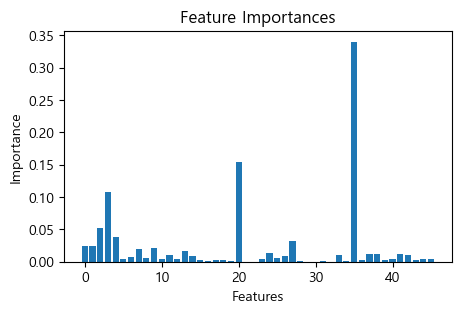

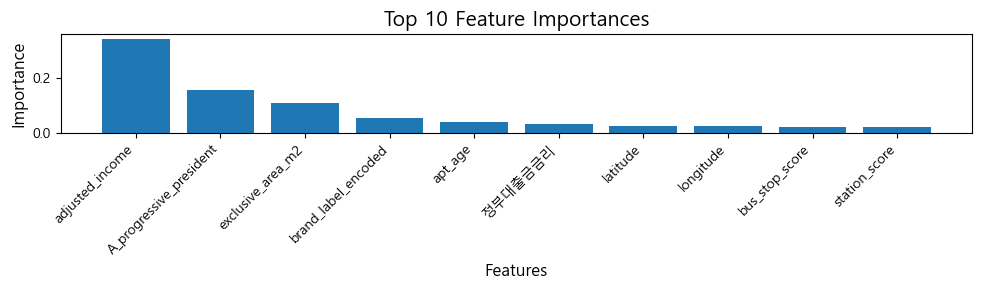

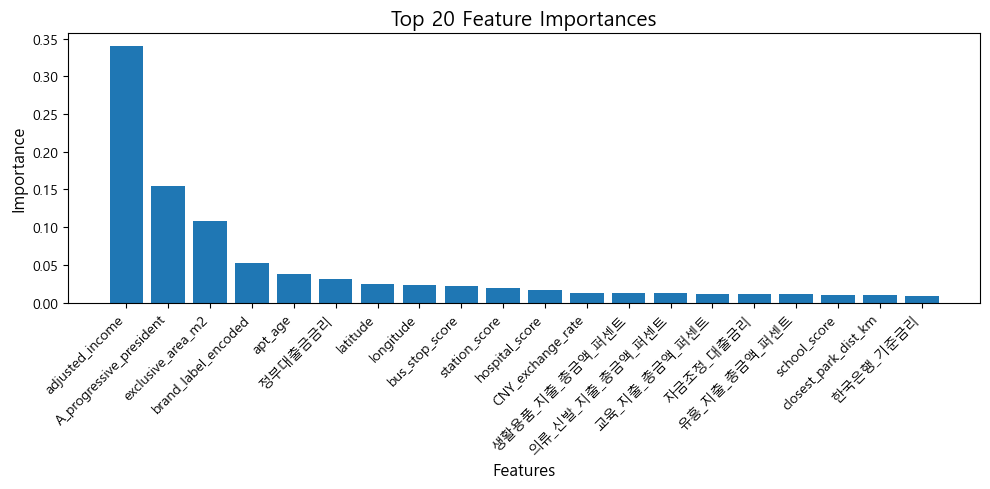

In [9]:
# 전체 Feature Importance 시각화
def plot_full_importances(model):
    plt.figure(figsize=(5, 3))
    plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
    plt.title('Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

# 상위 N개 Feature Importance 시각화
def plot_top_n_importances(model, feature_names, n=10):
    # 상위 N개 피처 추출
    top_n_indices = np.argsort(model.feature_importances_)[-n:][::-1]
    top_n_importances = model.feature_importances_[top_n_indices]
    top_n_names = [feature_names[i] for i in top_n_indices]
    
    # 시각화
    plt.figure(figsize=(10, 3 if n <= 10 else 5))  # 개수에 따라 크기 조정
    plt.bar(top_n_names, top_n_importances)
    plt.title(f'Top {n} Feature Importances', fontsize=15)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Feature 이름 리스트
feature_names = X_train.columns.tolist()

# 전체 Feature Importance 시각화
plot_full_importances(best_model)

# 상위 10개 Feature Importance 시각화
plot_top_n_importances(best_model, feature_names, n=10)

# 상위 20개 Feature Importance 시각화
plot_top_n_importances(best_model, feature_names, n=20)


In [10]:
print(df.corr().tail(1).to_string())

                      NO  latitude  longitude  brand_label_encoded  exclusive_area_m2   apt_age    floor  closest_station_dist_km  station_score  closest_bus_stop_dist_km  bus_stop_score  closest_school_dist_km  school_score  closest_hospital_dist_km  hospital_score  closest_park_dist_km  park_score  ldong_prev_1_month  ldong_prev_3_months  ldong_prev_6_months  K_progressive_president  A_progressive_president  A_progressive_senate  A_progressive_house  USD_exchange_rate  CNY_exchange_rate  JPY_exchange_rate  한국은행_기준금리   정부대출금금리  무역금융지원_프로그램대출금리  영세자영업자지원_프로그램대출금리  신성장·일자리지원_프로그램대출금리  설비투자지원_프로그램대출금리  지방중소기업지원_프로그램대출금리  자금조정_대출금리  자금조정_예금금리  adjusted_income  월_평균_소득_금액  식료품_지출_총금액_퍼센트  의류_신발_지출_총금액_퍼센트  생활용품_지출_총금액_퍼센트  의료비_지출_총금액_퍼센트  교통_지출_총금액_퍼센트  교육_지출_총금액_퍼센트  유흥_지출_총금액_퍼센트  여가_문화_지출_총금액_퍼센트  기타_지출_총금액_퍼센트  음식_지출_총금액_퍼센트  adjusted_price
adjusted_price  0.058904 -0.330289   0.133496             0.208638           0.631126  0.005115  0.18861                -0.112917         0.1637   

##### 3.3. 현재 화폐가치 반영한 소득 제외

In [35]:
# 현재화폐가치 반영한 소득 제외한 모델
# 교차검증 5회, 하이퍼파라미터 증가
sampled_df = df.sample(n=15000, random_state=42)

# 샘플링
sampled_df = df.sample(n=15000, random_state=42)

# 특성과 타겟 분리
X = sampled_df.drop(columns=['NO', 'adjusted_price', 'adjusted_income'])
y = sampled_df['adjusted_price']

# 데이터 분할: 80% 학습, 20% 테스트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 기본 XGBoost 모델 초기화
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train,y_train)

print('score:', xgb_model.score(X_train,y_train), xgb_model.score(X_test,y_test))

# 교차검증 (R² 기준)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print(f"교차검증 평균 R² 점수:", cv_scores)

# 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.5, 1.0, 1.5],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.1, 0.2, 0.3]
}

# GridSearch 실행
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적 파라미터와 점수
print(f"최적 하이퍼파라미터: {grid_search.best_params_}")
print(f"최적 R² 점수: {grid_search.best_score_:.4f}")

# 최적 모델
best_model = grid_search.best_estimator_

# 훈련 세트 예측
y_train_pred = best_model.predict(X_train)

# 훈련 세트 평가 지표 계산
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f"훈련 세트 R²: {r2_train}")
print(f"훈련 세트 MSE: {mse_train}")
print(f"훈련 세트 RMSE: {rmse_train}")
print(f"훈련 세트 MAE: {mae_train}")

# 테스트 세트 예측
y_pred = best_model.predict(X_test)

# 평가 지표 계산
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"테스트 세트 R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

np.round( mae / y_test.mean(), 3 )
# 0.105 > 집값의 약 10% 오차

best_model.feature_importances_

score: 0.9894812295900169 0.932571740500043
교차검증 평균 R² 점수: [0.93153309 0.92051068 0.89893381 0.91368027 0.9233492 ]
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


c:\Users\human\.conda\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3645 fits failed out of a total of 10935.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3645 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\human\.conda\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\human\.conda\envs\myenv\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\human\.conda\envs\myenv\lib\site-packages\xgboost\sklearn.py", line 1108, in fit
    self._Booster = train(
  File "c:\Users\human\.conda\envs\mye

최적 하이퍼파라미터: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 1.0}
최적 R² 점수: 0.9352
훈련 세트 R²: 0.9906340294196827
훈련 세트 MSE: 47686174.83083051
훈련 세트 RMSE: 6905.517709109905
훈련 세트 MAE: 4936.666090092333
테스트 세트 R²: 0.9399815180125667
MSE: 337457841.515593
RMSE: 18370.025626427225
MAE: 9708.470496755208


array([0.02788416, 0.02992471, 0.05587288, 0.11395261, 0.03825301,
       0.00620898, 0.00717901, 0.0134014 , 0.00347519, 0.01848986,
       0.00509847, 0.00591127, 0.00604565, 0.01541051, 0.00713156,
       0.00185571, 0.00164422, 0.00420168, 0.00229832, 0.00084394,
       0.11347317, 0.        , 0.00168083, 0.00483075, 0.01098438,
       0.00503899, 0.00627362, 0.03321529, 0.00293813, 0.        ,
       0.        , 0.00746006, 0.        , 0.01101204, 0.00259568,
       0.37434003, 0.00309416, 0.01301606, 0.01029023, 0.0033902 ,
       0.00387466, 0.00562947, 0.00962311, 0.00434708, 0.00389287,
       0.00391597], dtype=float32)

In [30]:
np.round( mae / y_test.mean(), 3 )


0.099

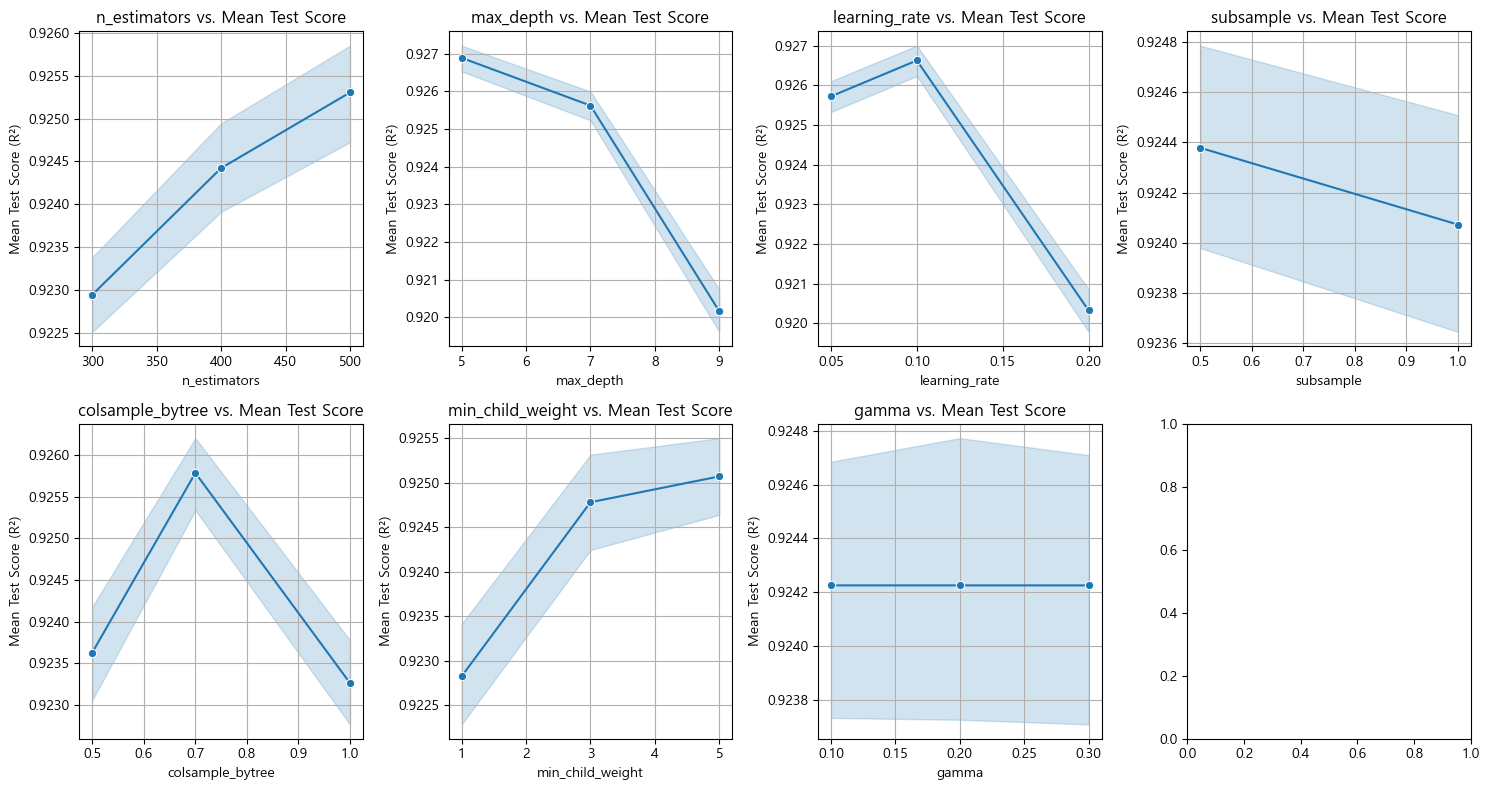

In [46]:
# GridSearchCV 결과를 DataFrame으로 변환
results = pd.DataFrame(grid_search.cv_results_)

# 하이퍼파라미터별 성능 시각화를 위한 서브플롯 설정
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 2행 4열로 그래프 배치
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 다룰 수 있도록 함

# 각 하이퍼파라미터에 대해 성능 시각화
params = ['param_n_estimators', 'param_max_depth', 'param_learning_rate',
          'param_subsample', 'param_colsample_bytree', 'param_min_child_weight', 'param_gamma']
titles = ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'min_child_weight', 'gamma']

for i, param in enumerate(params):
    sns.lineplot(data=results, x=param, y='mean_test_score', marker='o', ax=axes[i])
    axes[i].set_title(f'{titles[i]} vs. Mean Test Score')
    axes[i].set_xlabel(titles[i])
    axes[i].set_ylabel('Mean Test Score (R²)')
    axes[i].grid(True)

# 레이아웃 자동 조정
plt.tight_layout()
plt.show()


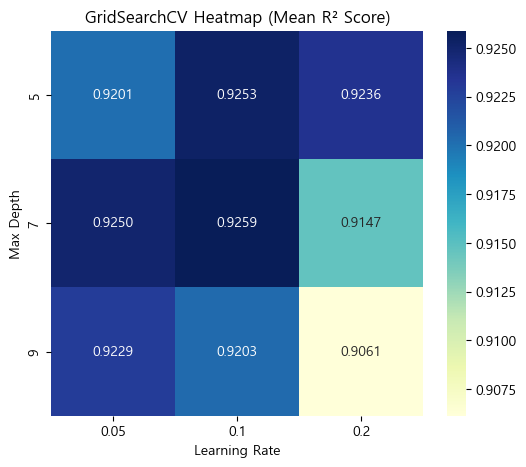

In [20]:
# 그리드 서치 결과에서 파라미터와 성능 점수 추출
results = grid_search.cv_results_

# 'mean_test_score' 값 추출
mean_scores = np.array(results['mean_test_score'])

# 'param_max_depth', 'param_learning_rate' 값 추출
max_depth_values = np.array(results['param_max_depth'], dtype=int)
learning_rate_values = np.array(results['param_learning_rate'], dtype=float)

# max_depth와 learning_rate를 기준으로 성능 점수를 2D로 재구성
# 여기서 max_depth와 learning_rate가 각각 조합될 수 있는 값들을 고정합니다.
unique_max_depth = np.unique(max_depth_values)
unique_learning_rate = np.unique(learning_rate_values)

# 2D 매트릭스로 성능 점수 구성
score_matrix = np.zeros((len(unique_max_depth), len(unique_learning_rate)))

# 점수 매트릭스 채우기
for i, depth in enumerate(unique_max_depth):
    for j, lr in enumerate(unique_learning_rate):
        score_matrix[i, j] = mean_scores[(max_depth_values == depth) & (learning_rate_values == lr)][0]

# 히트맵 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(score_matrix, annot=True, cmap="YlGnBu", fmt=".4f", xticklabels=unique_learning_rate, yticklabels=unique_max_depth)
plt.title('GridSearchCV Heatmap (Mean R² Score)')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.show()


In [36]:
max = best_model.feature_importances_.argmax()
print(max)
X_train.columns[max]

35


'월_평균_소득_금액'

특성 중요도 시각화

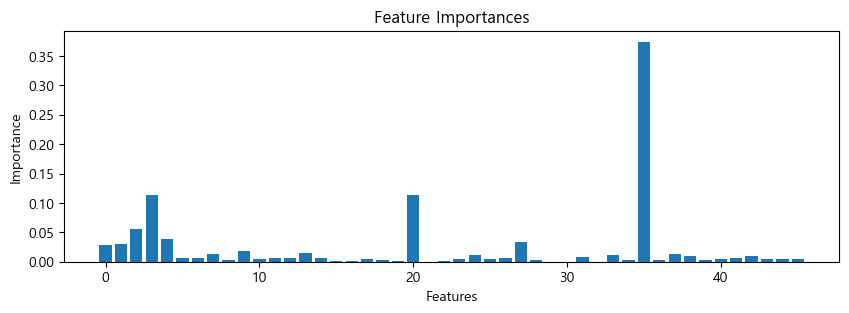

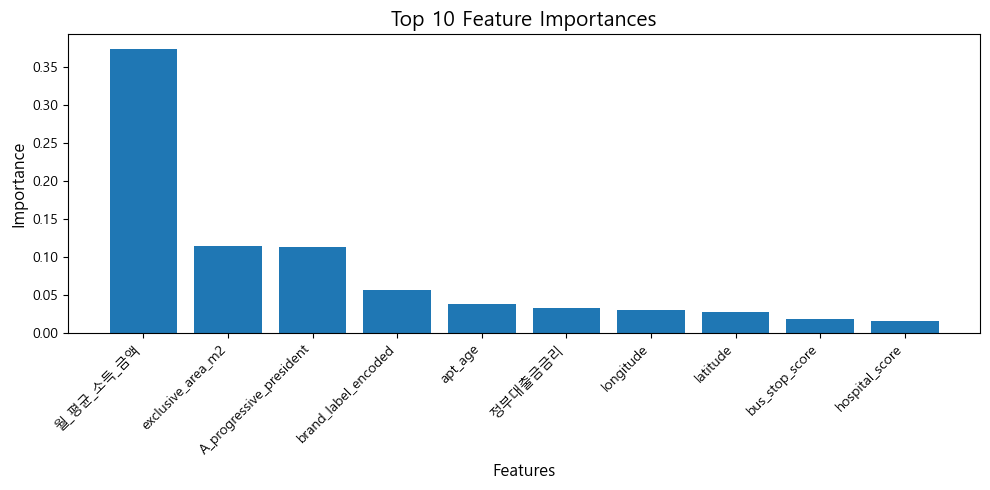

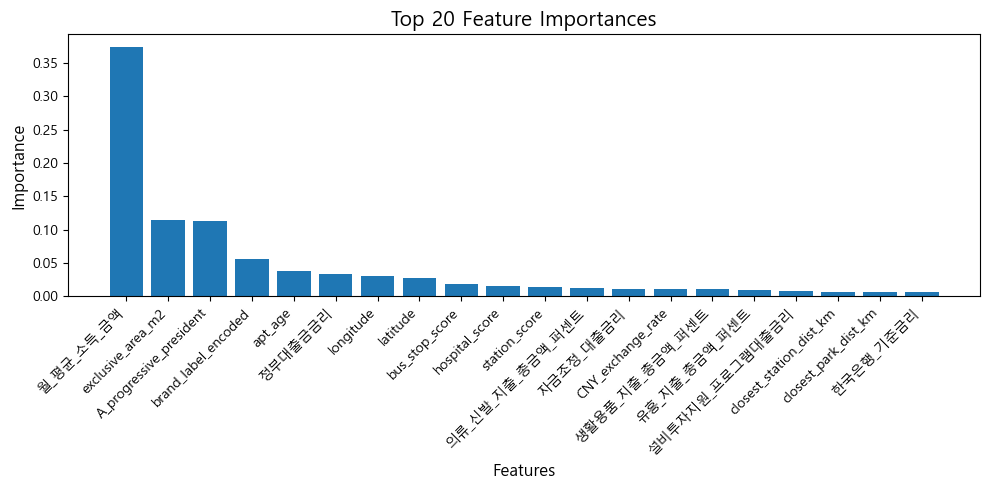

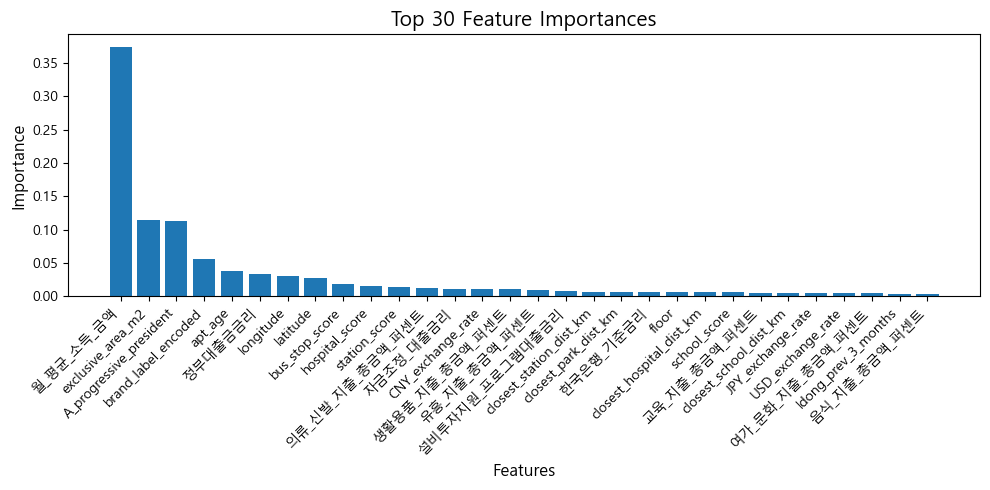

In [28]:
# 전체 Feature Importance 시각화
def plot_full_importances(model):
    plt.figure(figsize=(10, 3))
    plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
    plt.title('Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

# 상위 N개 Feature Importance 시각화
def plot_top_n_importances(model, feature_names, n=10):
    # 상위 N개 피처 추출
    top_n_indices = np.argsort(model.feature_importances_)[-n:][::-1]
    top_n_importances = model.feature_importances_[top_n_indices]
    top_n_names = [feature_names[i] for i in top_n_indices]
    
    # 시각화
    plt.figure(figsize=(10, 5 if n <= 10 else 5))  # 개수에 따라 크기 조정
    plt.bar(top_n_names, top_n_importances)
    plt.title(f'Top {n} Feature Importances', fontsize=15)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Feature 이름 리스트
feature_names = X_train.columns.tolist()

# 전체 Feature Importance 시각화
plot_full_importances(best_model)

# 상위 10개 Feature Importance 시각화
plot_top_n_importances(best_model, feature_names, n=10)

# 상위 20개 Feature Importance 시각화
plot_top_n_importances(best_model, feature_names, n=20)

# 상위 30개 Feature Importance 시각화
plot_top_n_importances(best_model, feature_names, n=30)


In [42]:
# 샘플링되지 않은 데이터 추출
unsampled_df = df[~df.index.isin(sampled_df.index)]

# 입력 데이터와 타깃 데이터 분리
X_unsampled = unsampled_df.drop(columns=['NO', 'adjusted_price', 'adjusted_income'])  # 독립 변수
y_unsampled = unsampled_df['adjusted_price']                # 종속 변수

# 예측 수행
y_unsampled_pred = best_model.predict(X_unsampled)

In [44]:
# 성능 지표 계산
r2_unsampled = r2_score(y_unsampled, y_unsampled_pred)
mse_unsampled = mean_squared_error(y_unsampled, y_unsampled_pred)
rmse_unsampled = np.sqrt(mse_unsampled)  # RMSE 계산
mae_unsampled = mean_absolute_error(y_unsampled, y_unsampled_pred)

# 결과 출력
print(f"샘플링되지 않은 데이터에 대한 성능:")
print(f"R²: {r2_unsampled}")
print(f"MSE: {mse_unsampled}")
print(f"RMSE: {rmse_unsampled}")
print(f"MAE: {mae_unsampled}")

샘플링되지 않은 데이터에 대한 성능:
R²: 0.9368897437907385
MSE: 314053828.95178574
RMSE: 17721.563953324938
MAE: 9660.696347662257
